In [1]:
 # Required package to load data 
import xarray as xr
import cdsapi
import os 
import warnings
import datetime

# Required packages for ploting 
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import subprocess
import glob
import pandas as pd 
# In order to run the 'wget' command, wget needs to be available. 
# On a Windows machine, it is probably easiest to simply place the 'wget.exe' file 
# (see https://www.gnu.org/software/wget/) in the same directory as this Norebook

# plotting/mapmaknig/
import geopandas as gpd
from geospatial_functions import get_background_map
import rasterio
from rasterio.plot import show as rioshow
import regionmask 

import numpy as np

In [2]:
path = os.getcwd()
home_path = os.path.dirname(path)
gis_folder = f'{home_path}\\GIS'
data_folder = f'{home_path}\\Data'

In [3]:
outline = gpd.read_file(f"{gis_folder}\\hudson_basin.gpkg",driver="GPKG",crs="EPSG:26918")
outline_buffered = gpd.read_file(f"{gis_folder}\\hudson_basin_buffered.gpkg",crs="EPSG:26918")
for layer in [outline,outline_buffered]:
    layer.geometry = layer.geometry.to_crs("EPSG:4326")

# Loading landsat data

In [4]:
# Define function to run wget command
def runcmd(cmd, verbose = False, *args, **kwargs):

    process = subprocess.Popen(
        cmd,
        stdout = subprocess.PIPE,
        stderr = subprocess.PIPE,
        text = True,
        shell = True
    )
    std_out, std_err = process.communicate()
    if verbose:
        print(std_out.strip(), std_err)
    pass

In [5]:
def run_download(url,verbose=False):
    cmd = 'wget -c --no-check-certificate -r -np -nH --user=daafip --password=Joyfully-Distant-Backer7' 
    cmd += ' -nd -R "*nd" ' # Only -nd relevant for METREF ### 15.nc, *30.nc, *45.nc
    cmd += url

    runcmd(cmd, verbose=verbose)
    
    source_path = glob.glob("*.nc")[0]
    destination_path = data_folder + '\\EP\\landsat.nc'
    movecmd = f'move "{source_path}" "{destination_path}"'
    runcmd(movecmd, verbose=True)

In [6]:
day=10
url = f'https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/MSG/MDMET/NETCDF/2023/03/{day}/'

In [7]:
run_download(url,verbose=False)

1 file(s) moved. 


In [8]:
ds = xr.open_dataset(data_folder + '\\EP\\landsat.nc')

In [9]:
ds.sel(lat=slice(-75,-70),lon=slice(40,50))

<xarray.Dataset>
Dimensions:                 (time: 1, lat: 0, lon: 201)
Coordinates:
  * lat                     (lat) float32 
  * lon                     (lon) float32 40.0 40.05 40.1 ... 49.9 49.95 50.0
  * time                    (time) datetime64[ns] 2023-03-10
Data variables:
    ET                      (time, lat, lon) float64 ...
    crs                     |S1 ...
    max_nslots_missing      (time, lat, lon) float64 ...
    missing_values_percent  (time, lat, lon) float64 ...
Attributes: (12/27)
    date_created:               2023-03-11T00:28:54Z
    algorithm_version:          2.0.0
    base_algorithm_version:     0.5.4
    processing_level:           04
    platform:                   MSG4
    sensor:                     SEVI
    ...                         ...
    westernmost_longitude:      80.0
    spatial_resolution:          0.05x 0.05
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    Conventions:                CF-1.6
    netcdf_version_id:          netCDF4

<GeoAxes: title={'center': 'time = 2023-03-10'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

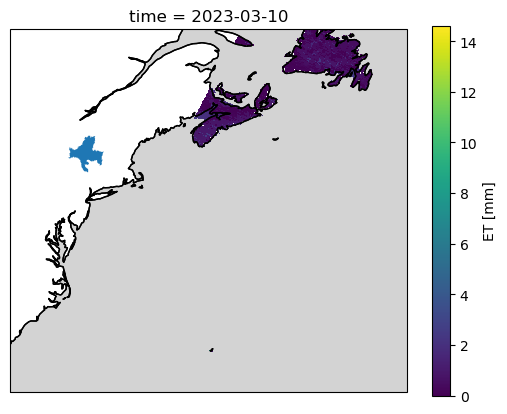

In [10]:
# to avoid showing warnings of cartopy
import warnings
warnings.filterwarnings('ignore')

# slot = lst_xr[3]
pvar = ds.ET.isel(time=0)
# ax = plt.axes(projection=ccrs.Orthographic(0, 0))  # to use the Orthographic projection 
ax = plt.axes(projection=ccrs.PlateCarree())      # to use simple lat/lon 
pvar.plot.imshow(ax=ax, transform=ccrs.PlateCarree(),interpolation='nearest')
ax.coastlines()
ax.coastlines()
ax.add_feature(cfeature.OCEAN, facecolor='lightgray')
ax.set_xlim((-80,-50))
ax.set_ylim((30,50))
outline.plot(ax=ax)

clearly falls outside our area, thus try another product

### Try era5 data:

### automatic dowload with api

make a list of years

In [11]:
year = datetime.timedelta(365)
years = []
prev_year_start = 2021

for i in range(8): # 70 years back
    prev_year = prev_year_start
    lst_years = []
    for i in range(10):
        next_year = datetime.datetime(prev_year,1,1) - year
        lst_years.append(str(next_year.year))
        prev_year = next_year.year
    
    years.append(lst_years[::-1])
    prev_year_start = next_year.year

In [12]:
print(years)

[['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'], ['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010'], ['1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000'], ['1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990'], ['1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980'], ['1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970'], ['1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960'], ['1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950']]


In [13]:
years[-1]

['1941',
 '1942',
 '1943',
 '1944',
 '1945',
 '1946',
 '1947',
 '1948',
 '1949',
 '1950']

In [14]:
# for year in years:
#     get_era_5(year)

In [15]:
def get_era_5(year):
    c = cdsapi.Client()
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'format': 'netcdf',
            'variable': 'potential_evaporation',
            'year': year,
            'month': [str(x) for x in list(np.linspace(1,12,12,dtype=int))], # all
            'day': [str(x) for x in list(np.linspace(1,31,31,dtype=int))],   # all
            'time': [
                '00:00', '01:00', '02:00',
                '03:00', '04:00', '05:00',
                '06:00', '07:00', '08:00',
                '09:00', '10:00', '11:00',
                '12:00', '13:00', '14:00',
                '15:00', '16:00', '17:00',
                '18:00', '19:00', '20:00',
                '21:00', '22:00', '23:00',
            ],
            'area': [46, -76, 39,-70,],                                       # bounding box of chosen region
        },
        f'Era5_{year[0]}-{year[-1]}.nc')

In [16]:
run = False # depends on availibility of file: can take a while
if run:
    get_era_5(years[-1])

In [17]:
years[1]

['2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010']

Grib files take long to load, but this works too

In [18]:
run = False
if run:
    grib_files = glob.glob(f'{data_folder}\\EP\\*.grib')
    ds = xr.load_dataset(grib_files[0],engine="cfgrib")
    
    ds_daily = ds.sum(dim="step")
    time = ds_daily.time.to_pandas()
    time = pd.DataFrame(data=time, columns=["hour"])
    
    timesplit = time.apply(lambda x: x.index.hour)
    timesplit = timesplit.iloc[1:] # remove unwanted first value
    
    index_18_00s = timesplit[timesplit.hour == 18]
    index_06_00s = timesplit[timesplit.hour == 6]
    index_18_00s["new_time"] = index_18_00s.apply(lambda x: x.index - datetime.timedelta(hours=12))
    
    ds_18 = ds_daily.sel(time=index_18_00s.index)
    ds_18["time"] = index_18_00s.new_time.values
    ds_16 = ds_daily.sel(time=index_06_00s.index)
    
    ds_combined = ds_18 + ds_16
    
    series_pev = ds_combined.mean(dim=["latitude","longitude"]).pev.to_pandas()
    df_pev = pd.DataFrame(data=series_pev,columns=["Pev"])
    df_pev.Pev = df_pev.Pev * - 1000 
    
    fig, [ax1,ax] = plt.subplots(2,1)
    df_pev.plot(ax=ax1)
    ax1.set_ylim(0,2.5)
    ax1.set_title("ERA5 evaporation")
    
    pvar = ds_combined.isel(time=0).pev
    # ax = plt.axes(projection=ccrs.Orthographic(0, 0))  # to use the Orthographic projection 
    ax = plt.axes(projection=ccrs.PlateCarree())      # to use simple lat/lon 
    pvar.plot.imshow(ax=ax, transform=ccrs.PlateCarree(),interpolation='nearest')
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN, facecolor='lightgray')
    ax.set_xlim((-77,-68))
    ax.set_ylim((38,47))
    outline.plot(ax=ax, edgecolor="C3", facecolor="None")

load outline of the basin

### Try again but with  hourly data different data set:

These are large files so are not in the project folder

In [19]:
year = years[1]
path = f"C:\\Users\\david\\Documents\\EP_data_ENVM1502\\Era5_{year[0]}-{year[-1]}.nc"

In [20]:
ds = xr.open_dataset(path)

Remove the positive values which are condensation which aren't interesting to us

In [21]:
ds.pev.values[ds.pev.values > 0] = 0

In [22]:
cmap = mpl.cm.get_cmap("RdBu")

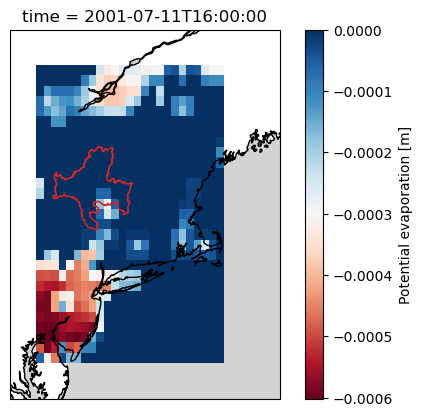

In [23]:
pvar = ds.pev.isel(time=4600)
# ax = plt.axes(projection=ccrs.Orthographic(0, 0))  # to use the Orthographic projection 
ax = plt.axes(projection=ccrs.PlateCarree())      # to use simple lat/lon 
pvar.plot.imshow(ax=ax, transform=ccrs.PlateCarree(),interpolation='nearest',cmap=cmap)
ax.coastlines()
ax.add_feature(cfeature.OCEAN, facecolor='lightgray')
ax.set_xlim((-77,-68))
ax.set_ylim((38,47))
outline.plot(ax=ax, edgecolor="C3", facecolor="None");

We want to crop our region out of the mask as it currently includes a lot of ocean, when we take the mean, this causes discrepancies

In [24]:
lon = np.arange(-76, -70+0.25, 0.25)
lat = np.arange( 39,  46+0.25, 0.25)
mask = regionmask.mask_geopandas(outline_buffered, lon, lat,lon_name="longitude",lat_name="latitude")

In [25]:
cropped_ds = ds.where(mask==0)

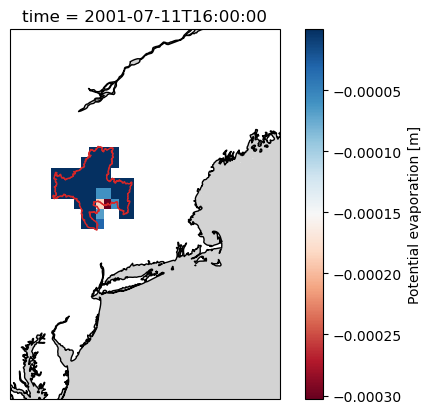

In [26]:
pvar = cropped_ds.pev.isel(time=4600)
# ax = plt.axes(projection=ccrs.Orthographic(0, 0))  # to use the Orthographic projection 
ax = plt.axes(projection=ccrs.PlateCarree())      # to use simple lat/lon 
pvar.plot.imshow(ax=ax, transform=ccrs.PlateCarree(),interpolation='nearest',cmap=cmap)
ax.coastlines()
ax.add_feature(cfeature.OCEAN, facecolor='lightgray')
ax.set_xlim((-77,-68))
ax.set_ylim((38,47))
outline.plot(ax=ax, edgecolor="C3", facecolor="None");

<!-- The most recept month use `ERA5T` which is `expver=5`, whilst newer data is `ERA5` which is `expver=1`: combine these two -->

For now  the mean can be take over the area (could be changed later)

In [27]:
ds_combine_mean = cropped_ds.mean(dim=["latitude","longitude"])

And resample to daily:

In [28]:
ds_combine_daily = ds_combine_mean.resample(time="1D").sum()

Export data into df

In [29]:
series_pev = ds_combine_daily.pev.to_pandas()
df_pev = pd.DataFrame(data=series_pev,columns=["Pev"])
df_pev.Pev = df_pev.Pev * - 1000 # m -> m & evap is evaporation is negative as it leaves the earth
# reset index to hr 00:00:00 to match othrer data
df_pev.index = df_pev.index - datetime.timedelta(hours=6)

<Axes: xlabel='time'>

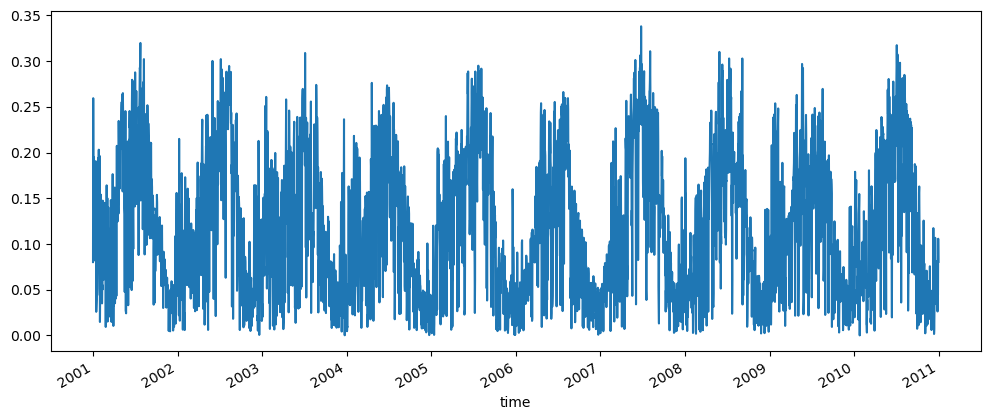

In [30]:
fig, ax = plt.subplots(1, figsize=(12,5))
df_pev["Pev"].plot(ax=ax)

## Now repeat for all years:

First create a mask to be used by all

In [31]:
lon = np.arange(-76, -70+0.25, 0.25)
lat = np.arange( 39,  46+0.25, 0.25)
mask = regionmask.mask_geopandas(outline_buffered, lon, lat,lon_name="longitude",lat_name="latitude")

In [32]:
path_PE_out = f"{data_folder}\\EP\\combined_PE.parquet"
if os.path.exists(path_PE_out):
    df_pev_combined = pd.read_parquet(path_PE_out)
else:
    lst_pev = []
    for index, year in enumerate(years[:-1]):
        print(f"{index+1}/{len(years)}",end="\r")
        ## load from local data (not on git due to space contraints)
        path = f"C:\\Users\\david\\Documents\\EP_data_ENVM1502\\Era5_{year[0]}-{year[-1]}.nc"
        ds = xr.open_dataset(path)

        ## only keep evap, not condensation
        ds.pev.values[ds.pev.values > 0] = 0

        ## crop the area with the above mask
        cropped_ds = ds.where(mask==0)

        ## for now take the mean
        ds_combine_mean = cropped_ds.mean(dim=["latitude","longitude"])

        ## sum all timesteps
        ds_combine_daily = ds_combine_mean.resample(time="1D").sum()

        ## export to pandas 
        series_pev = ds_combine_daily.pev.to_pandas()
        df_pev = pd.DataFrame(data=series_pev,columns=[f"Pev"])
        # fix units
        df_pev.Pev = df_pev.Pev * - 1000 # m -> m & evap is evaporation is negative as it leaves the earth

        ## probably not needed anymore
        # df_pev.rename(columns={"Pev":f"{year[0]}"})
        lst_pev.append(df_pev)
        
    # put all years under one another
    df_pev_combined = pd.concat(lst_pev,axis=0)
    df_pev_combined.to_parquet(path_PE_out)

In [33]:
df_pev_combined

,Pev
time,
2011-01-01,0.125836
2011-01-02,0.035201
2011-01-03,0.240013
2011-01-04,0.219147
2011-01-05,0.191367
...,...
1960-12-27,0.152401
1960-12-28,0.265924
1960-12-29,0.161177


compare to the previous data

In [34]:
files = glob.glob(f"{data_folder}\\*.parquet")
files

['C:\\Users\\david\\Documents\\@@ Python\\Jaar 5\\Q3\\ENVM1502\\Git\\ENVM1502-Catchment-model\\Data\\combined_data.parquet']

In [35]:
df_data = pd.read_parquet(files[0])

In [36]:
df_data

,T,Pev,P,Q
1980-01-01,-4.244118,0.212411,0.000000,1.432909
1980-01-02,-3.066830,0.167835,0.000000,1.367777
1980-01-03,-6.372549,0.235660,0.023756,1.335211
1980-01-04,-10.202124,0.167202,0.000000,1.253795
1980-01-05,-7.726471,0.192151,0.000000,1.179358
...,...,...,...,...
2020-12-27,-3.492917,0.389499,0.339976,6.350391
2020-12-28,-0.740625,0.698338,0.011413,4.210333
2020-12-29,-2.423333,0.540658,1.005240,3.082150
2020-12-30,-5.392857,0.307142,0.321450,2.388957


<Axes: xlabel='time'>

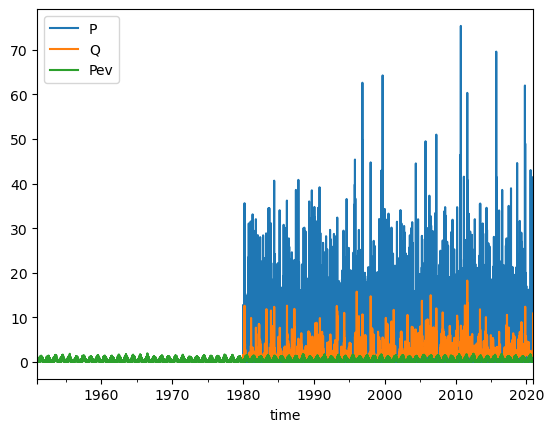

In [37]:
fig, ax = plt.subplots(1)
df_data[["P","Q"]].plot(ax=ax)
df_pev_combined.plot(ax=ax)

###  loading provided era5 data 

In [38]:
files = glob.glob(f"{data_folder}\\ERA5_Group18_*.nc")
ds = xr.open_dataset(files[0])

In [39]:
ds

<xarray.Dataset>
Dimensions:    (time: 2191, lat: 15, lon: 13, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01T12:00:00 ... 2015-12-31T12:00:00
  * lat        (lat) float64 40.75 41.0 41.25 41.5 ... 43.5 43.75 44.0 44.25
  * lon        (lon) float64 284.2 284.5 284.8 285.0 ... 286.5 286.8 287.0 287.2
    height     float64 ...
    shape_id   |S1 ...
Dimensions without coordinates: bnds
Data variables:
    tas        (time, lat, lon) float32 ...
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes:
    software:     Created with ESMValTool v2.4.0
    Conventions:  CF-1.7
    caption:      Forcings for the HBVmountain hydrological model.

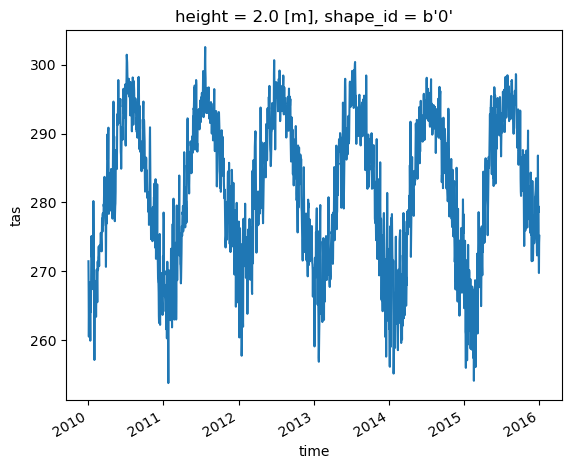

In [40]:
ds.mean(dim=["lat","lon"]).tas.plot()

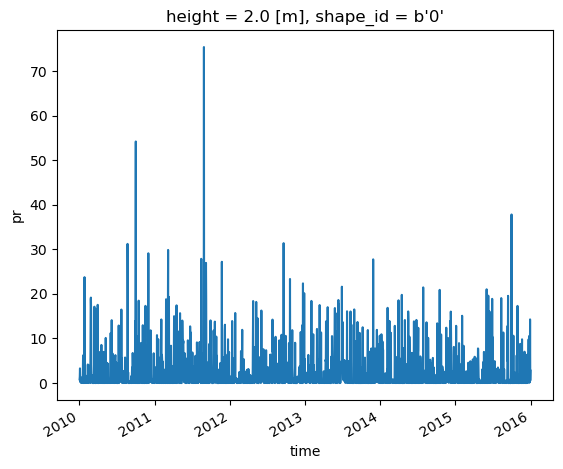

In [41]:
ds_pr = ds.sum(dim=["lat","lon"]).pr * 1000
ds_pr.plot()

Due to limited time span less interesting for us